In [1]:
from tqdm.auto import tqdm
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('..')

import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from src.solvers import DensitySolver
from src.task import Environment
from src.utils import get_data

DATA_ROOT = '../data'
TERMINAL_DATA_PATH = os.path.join(DATA_ROOT, 'terminal_data_hackathon v4.xlsx')
TIMES_DATA_PATH = os.path.join(DATA_ROOT, 'times v4.csv')

In [2]:
moscow = gpd.read_file("ao-shape.zip")
terminals, time_matrix = get_data(DATA_ROOT)
business_logic = Environment()
t_nums = {}
for armored_num in tqdm(range(1, 53, 2)):
    solver = DensitySolver(terminals['start_value'].values, time_matrix, business_logic, armored_num=armored_num)
    routes = solver.get_routes()
    t_nums[armored_num] = sum([len(route) for route in routes])


KeyboardInterrupt



In [79]:
from src.tools.evaluate import get_losses
from IPython.core.display_functions import clear_output
import itertools


def visualize(title: str):
    fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
    moscow.plot(ax=ax[0])
    color_vals = terminals['remains 91']  # np.median(terms[columns[2:]].values, axis=1).clip(1e-6)
    ax[0].scatter(terminals['longitude'], terminals['latitude'], s=0.6, c=color_vals,
               norm=colors.LogNorm(vmin=color_vals.min(), vmax=color_vals.max()), cmap='YlOrRd')

    for route in routes:
        ax[0].plot(terminals['longitude'].loc[route], terminals['latitude'].loc[route], linewidth=0.8)

    ax[0].axis('off')
    ax[0].set_title('Терминалы на карте')

    n_bins = solver.days_after_service.max() + 1
    n, bins, patches = ax[1].hist(solver.days_after_service, bins=n_bins, rwidth=0.85, align='mid')
    ax[1].set_title('Распределение кол-ва необслуживаемых дней')
    ax[1].set_xlabel('Число необслуживаемых дней')
    ax[1].set_ylabel('Кол-во терминалов')
    ticks = [(2 * patch.get_x() + patch.get_width()) / 2 for patch in patches]
    ticklabels = [i for i in range(n_bins)]
    ax[1].set_xticks(ticks, ticklabels)

    plt.suptitle(title)
    plt.show()


terminals_count = []
moscow = gpd.read_file("ao-shape.zip")
terminals, time_matrix = get_data(DATA_ROOT)
business_logic = Environment()
t_nums = {}
visited = []
solver = DensitySolver(terminals['start_value'].values, time_matrix, business_logic, armored_num=5, sigma=500)

total_losses = []
for day in tqdm(range(91)):
    routes = solver.get_routes()
    solver.update(terminals[f'day {day + 1}'])
    t_nums[day] = sum([len(route) for route in routes])
    visited.extend(list(itertools.chain(*routes)))
    #clear_output()
    terminals_count.append(sum([len(route) for route in routes]))
    losses = get_losses(routes, solver.remains, len(terminals), solver.environment)
    total_losses.append(losses)
    #if (day + 1) % 10 == 0:
    #    print(sum(total_losses[-10:]))
    #visualize(f'День {day + 1}')

  0%|          | 0/91 [00:00<?, ?it/s]

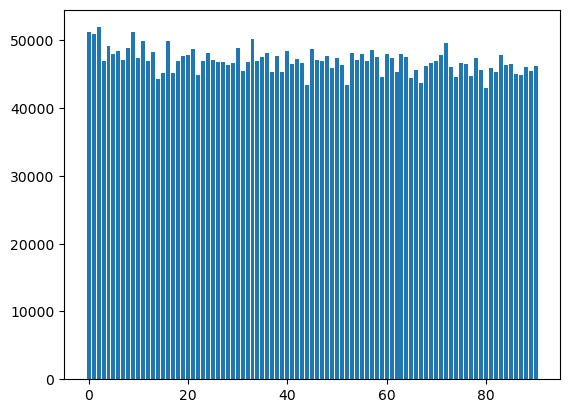

13.37637152191781

In [78]:
plt.bar(list(range(91)), total_losses)
plt.show()
(np.sum(total_losses) + 91 * 100000) / 1_000_000

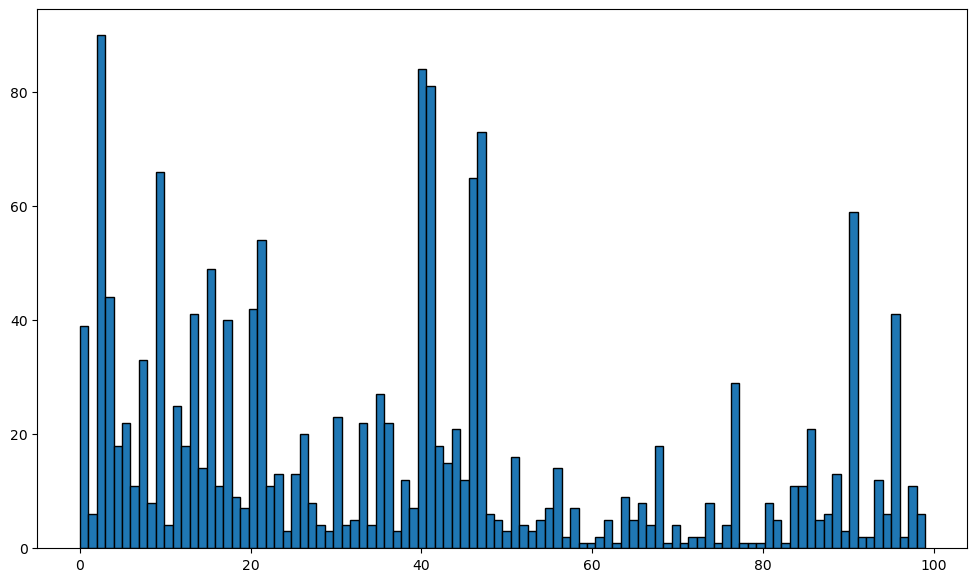

In [5]:
from sklearn.cluster import AgglomerativeClustering

# clustering = DBSCAN(eps=9, min_samples=5, metric='precomputed').fit(time_matrix)
# clustering = AffinityPropagation(affinity='precomputed').fit(time_matrix)
clustering = AgglomerativeClustering(n_clusters=100, affinity='precomputed', linkage='complete').fit(time_matrix)
plt.figure(figsize=(12, 7))
plt.hist(clustering.labels_, ec='black', bins=100)
plt.show()

In [55]:
# top_idx = np.argsort(-solver.density)[-100:]
top_idx = np.where(clustering.labels_ == 0)[0]

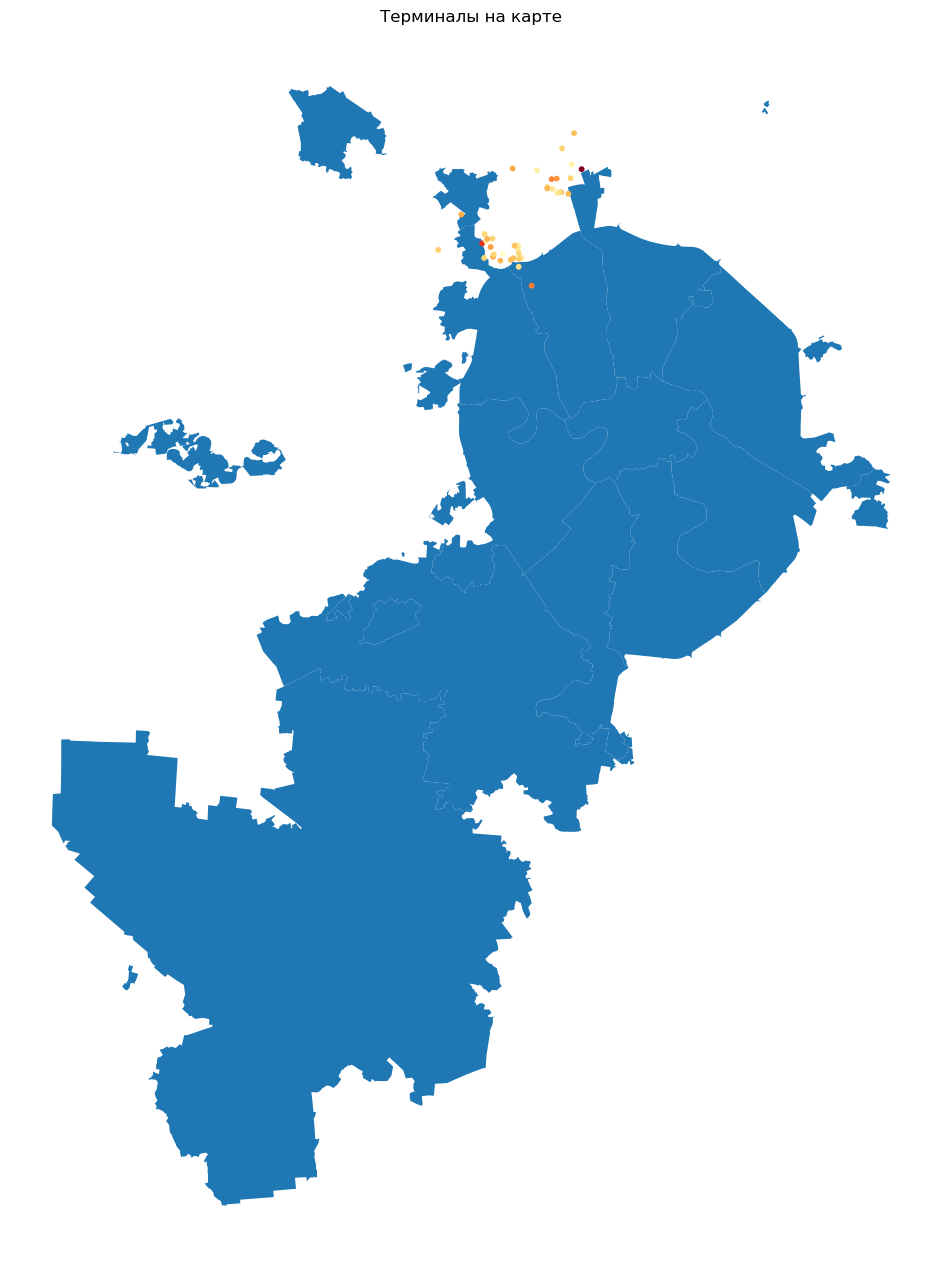

In [56]:
fig, ax = plt.subplots(figsize=(16, 16))
moscow.plot(ax=ax)
color_vals = terminals['remains 91'].iloc[top_idx]  # np.median(terms[columns[2:]].values, axis=1).clip(1e-6)
ax.scatter(terminals['longitude'].iloc[top_idx], terminals['latitude'].iloc[top_idx], s=10, c=color_vals,
           norm=colors.LogNorm(vmin=color_vals.min(), vmax=color_vals.max()), cmap='YlOrRd')

plt.axis('off')
plt.title('Терминалы на карте')
plt.show()

In [ ]:
def visualize():
    fig, ax = plt.subplots(figsize=(16, 16))
    moscow.plot(ax=ax)
    color_vals = terminals['remains 91']  # np.median(terms[columns[2:]].values, axis=1).clip(1e-6)
    ax.scatter(terminals['longitude'], terminals['latitude'], s=10, c=color_vals,
               norm=colors.LogNorm(vmin=color_vals.min(), vmax=color_vals.max()), cmap='YlOrRd')

    for route in routes:
        plt.plot(terminals['longitude'].loc[route], terminals['latitude'].loc[route])

    plt.axis('off')
    plt.title('Терминалы на карте')
    plt.show()